In [15]:
import pandas as pd
import os
import subprocess
from glob import glob
import tqdm 

# Preparing input, puro only RT to start

In [17]:
for file_name in tqdm.tqdm(glob("../../output/NKX2-2/TL4B2/puro_only/no_err_corr/*RTBC*/*umi.tsv")):    
    # Load TSV
    file_RTBC_reads_per_umi = pd.read_csv(file_name, sep="\t")
    
    # Group by molecule
    file_molecule_counts = (
        file_RTBC_reads_per_umi
        .groupby(["RTBC", "UMI"], as_index=False)["reads"]
        .sum()
    )

    # Save counts file in same folder as input
    counts_file = os.path.join(os.path.dirname(file_name), "preseq_input.txt")
    file_molecule_counts["reads"].to_csv(counts_file, index=False, header=False)
    

100%|██████████| 16/16 [01:15<00:00,  4.74s/it]


In [6]:
pd.read_csv("/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/NKX2-2/TL4B2/puro_only/no_err_corr/trebl_experiment_r9_RTBC_Puro_Only_R1_T24_S106/r9_RTBC_Puro_Only_R1_T24_S106_reads_per_umi.tsv", sep = "\t")

,Unnamed: 0,RTBC,UMI,reads,name
0,0,AAAAAAAAAAAACGAT,GAGCAATTGTCA,5,r9_RTBC_Puro_Only_R1_T24_S106
1,1,AAAAAAAAAAAACGAT,TAACGATTAGCC,5,r9_RTBC_Puro_Only_R1_T24_S106
2,2,AAAAAAAAAAAACGAT,AATTTTTCATAT,3,r9_RTBC_Puro_Only_R1_T24_S106
3,3,AAAAAAAAAAAACGAT,CGTTTAGTTCAC,3,r9_RTBC_Puro_Only_R1_T24_S106
4,4,AAAAAAAAAAAACGAT,TTAAGCCGAGAT,3,r9_RTBC_Puro_Only_R1_T24_S106
...,...,...,...,...,...
2633946,2633946,TTTTTGTACGAGTAGA,CACCGTGTCCCA,5,r9_RTBC_Puro_Only_R1_T24_S106
2633947,2633947,TTTTTGTACGAGTAGA,GTTCCCTACGAT,1,r9_RTBC_Puro_Only_R1_T24_S106
2633948,2633948,TTTTTGTACGAGTAGA,CTAAGACTTACC,1,r9_RTBC_Puro_Only_R1_T24_S106
2633949,2633949,TTTTTGTACGAGTAGA,TGGTAAAAAGGC,1,r9_RTBC_Puro_Only_R1_T24_S106


# Running preseq

In [28]:
# Path to your preseq binary in the conda env
preseq_bin = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/conda/preseq/bin/preseq"

# Base directory containing umi_* folders
BASE_DIR = "../../output/NKX2-2/TL4B2/puro_only/no_err_corr/"

# Find all umi_* directories
umi_dirs = sorted(glob(os.path.join(BASE_DIR, "*RTBC*")))

print(f"Found {len(umi_dirs)} UMI directories")
umi_dirs

Found 16 UMI directories


['../../output/NKX2-2/TL4B2/puro_only/no_err_corr/trebl_experiment_r10_RTBC_Puro_Only_R2_T24_S107',
 '../../output/NKX2-2/TL4B2/puro_only/no_err_corr/trebl_experiment_r11_RTBC_Puro_Only_R3_T24_S108',
 '../../output/NKX2-2/TL4B2/puro_only/no_err_corr/trebl_experiment_r12_RTBC_Puro_Only_R4_T24_S109',
 '../../output/NKX2-2/TL4B2/puro_only/no_err_corr/trebl_experiment_r13_RTBC_Puro_Only_R1_T48_S110',
 '../../output/NKX2-2/TL4B2/puro_only/no_err_corr/trebl_experiment_r14_RTBC_Puro_Only_R2_T48_S111',
 '../../output/NKX2-2/TL4B2/puro_only/no_err_corr/trebl_experiment_r15_RTBC_Puro_Only_R3_T48_S112',
 '../../output/NKX2-2/TL4B2/puro_only/no_err_corr/trebl_experiment_r16_RTBC_Puro_Only_R4_T48_S113',
 '../../output/NKX2-2/TL4B2/puro_only/no_err_corr/trebl_experiment_r17_RTBC_Puro_Only_R1_T0_S114',
 '../../output/NKX2-2/TL4B2/puro_only/no_err_corr/trebl_experiment_r18_RTBC_Puro_Only_R2_T0_S115',
 '../../output/NKX2-2/TL4B2/puro_only/no_err_corr/trebl_experiment_r19_RTBC_Puro_Only_R3_T0_S116',
 '.

In [21]:
# Loop over directories and run preseq
for umi_dir in umi_dirs:
    input_file = os.path.join(umi_dir, "preseq_input.txt")
    output_file = os.path.join(umi_dir, "preseq_yield.txt")

    if not os.path.exists(input_file):
        print(f"Missing input: {input_file}")
        continue

    cmd = [
        preseq_bin,
        "lc_extrap",
        "-V",
        input_file,
        "-o",
        output_file
    ]

    print(f"▶ Running preseq on {os.path.basename(umi_dir)}")

    try:
        subprocess.run(
            cmd,
            check=True,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True
        )
        print(f"Saved: {output_file}")

    except subprocess.CalledProcessError as e:
        print(f"preseq failed for {umi_dir}")
        print(e.stderr)

▶ Running preseq on trebl_experiment_r10_RTBC_Puro_Only_R2_T24_S107
Saved: ../../output/NKX2-2/TL4B2/puro_only/no_err_corr/trebl_experiment_r10_RTBC_Puro_Only_R2_T24_S107/preseq_yield.txt
▶ Running preseq on trebl_experiment_r11_RTBC_Puro_Only_R3_T24_S108
Saved: ../../output/NKX2-2/TL4B2/puro_only/no_err_corr/trebl_experiment_r11_RTBC_Puro_Only_R3_T24_S108/preseq_yield.txt
▶ Running preseq on trebl_experiment_r12_RTBC_Puro_Only_R4_T24_S109
Saved: ../../output/NKX2-2/TL4B2/puro_only/no_err_corr/trebl_experiment_r12_RTBC_Puro_Only_R4_T24_S109/preseq_yield.txt
▶ Running preseq on trebl_experiment_r13_RTBC_Puro_Only_R1_T48_S110
Saved: ../../output/NKX2-2/TL4B2/puro_only/no_err_corr/trebl_experiment_r13_RTBC_Puro_Only_R1_T48_S110/preseq_yield.txt
▶ Running preseq on trebl_experiment_r14_RTBC_Puro_Only_R2_T48_S111
Saved: ../../output/NKX2-2/TL4B2/puro_only/no_err_corr/trebl_experiment_r14_RTBC_Puro_Only_R2_T48_S111/preseq_yield.txt
▶ Running preseq on trebl_experiment_r15_RTBC_Puro_Only_R3_T

# Analyzing results

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import os

# -------------------------------
# Parameters
# -------------------------------
DOWNSAMPLE = 10

# -------------------------------
# Find preseq output files
# -------------------------------
preseq_files = glob(os.path.join(BASE_DIR, "*RTBC*", "preseq_yield.txt"))
print(f"Found {len(preseq_files)} preseq yield files")


Found 16 preseq yield files


trebl_experiment_r5_RTBC_Puro_Only_R1_T4_S102: slope at last point = 0.0000


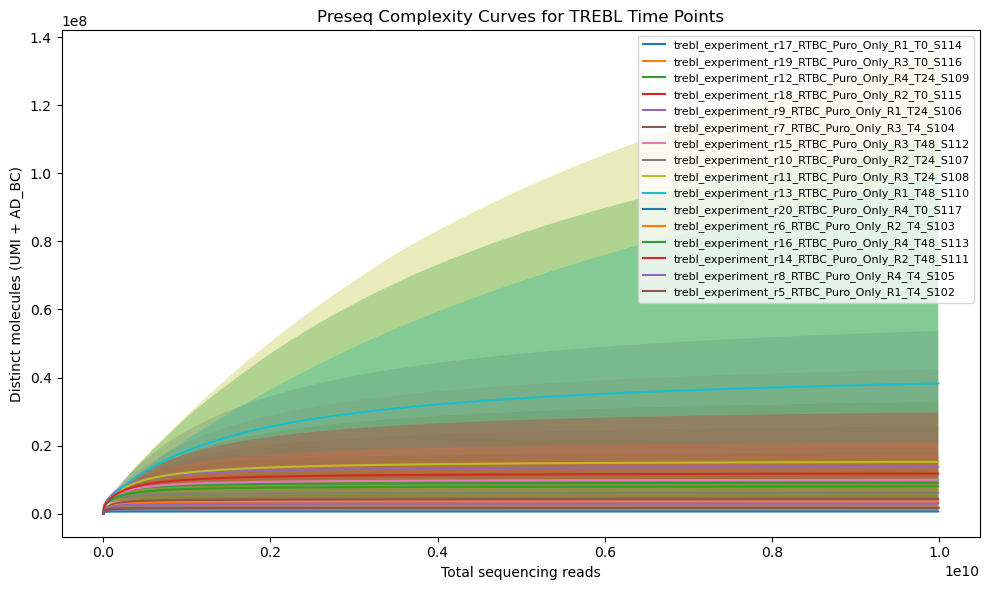

In [24]:

# -------------------------------
# Plot all curves
# -------------------------------
plt.figure(figsize=(10,6))

for f in preseq_files:

    df = pd.read_csv(
            f,
            sep='\t',
            comment='#',
            header=None,
            names=['total_reads', 'expected_distinct', 'lower_CI', 'upper_CI']
        )
        
    # Convert to numeric
    df = df.apply(pd.to_numeric, errors='coerce').dropna()
    
    # Downsample
    df = df.iloc[::DOWNSAMPLE, :]
    
    folder_name = os.path.basename(os.path.dirname(f))
    
    # Plot expected curve
    plt.plot(df['total_reads'], df['expected_distinct'], label=folder_name)
    
    # Plot shaded CI
    plt.fill_between(df['total_reads'], df['lower_CI'], df['upper_CI'], alpha=0.3)

# Compute slope at last point safely
if len(df) > 1:
    slope = (df['expected_distinct'].iloc[-1] - df['expected_distinct'].iloc[-2]) / \
            (df['total_reads'].iloc[-1] - df['total_reads'].iloc[-2])
    print(f"{folder_name}: slope at last point = {slope:.4f}")
else:
    print(f"{folder_name}: not enough points to compute slope")


plt.xlabel("Total sequencing reads")
plt.ylabel("Distinct molecules (UMI + AD_BC)")
plt.title("Preseq Complexity Curves for TREBL Time Points")
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

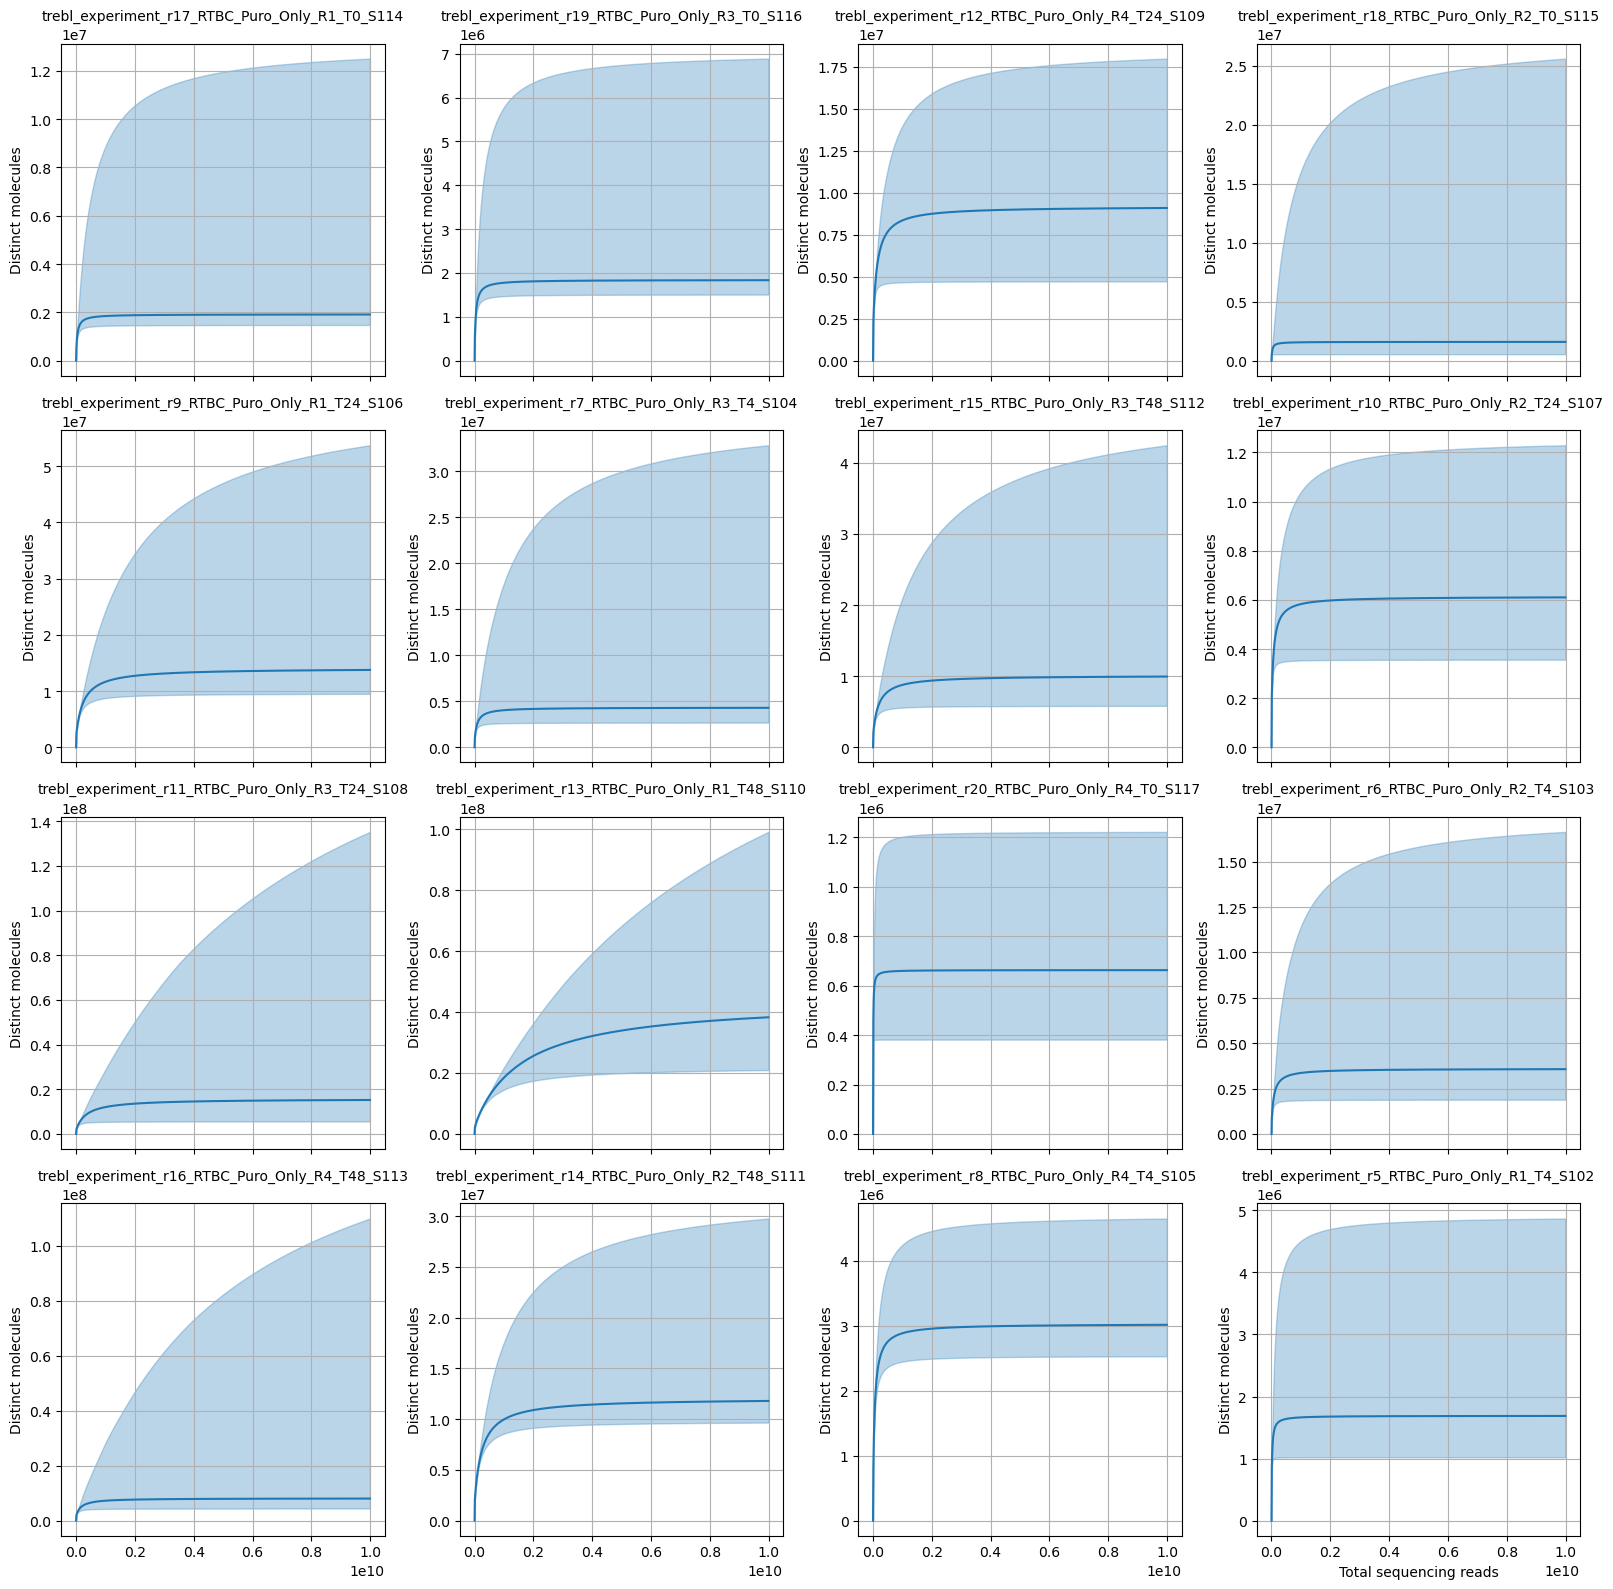

In [33]:

# -------------------------------
# Create subplots: one row per file
# -------------------------------
n_files = len(preseq_files)
fig, axes = plt.subplots(4, 4, figsize=(16,16), sharex=True)

axes = axes.flatten()

for ax, f in zip(axes, preseq_files):
    df = pd.read_csv(
        f,
        sep='\t',
        comment='#',
        header=None,
        names=['total_reads', 'expected_distinct', 'lower_CI', 'upper_CI']
    )
    
    # Convert to numeric and drop NaNs
    df = df.apply(pd.to_numeric, errors='coerce').dropna()
    
    # Downsample for faster plotting
    df = df.iloc[::DOWNSAMPLE, :]
    
    folder_name = os.path.basename(os.path.dirname(f))
    
    # Extract time point (between "2_" and "_MVS")
    if "2_" in folder_name and "_MVS" in folder_name:
        time_pt = folder_name.split("2_")[1].split("_MVS")[0]
        title = f"Time point: {time_pt}"
    else:
        title = folder_name
    
    # Plot curve
    ax.plot(df['total_reads'], df['expected_distinct'], color='tab:blue')
    
    # Plot shaded confidence interval
    ax.fill_between(df['total_reads'], df['lower_CI'], df['upper_CI'], color='tab:blue', alpha=0.3)
    
    ax.set_ylabel("Distinct molecules")
    ax.set_title(title, fontsize=10)
    ax.grid(True)

axes[-1].set_xlabel("Total sequencing reads")
plt.tight_layout()
plt.show()

Found 16 preseq yield files


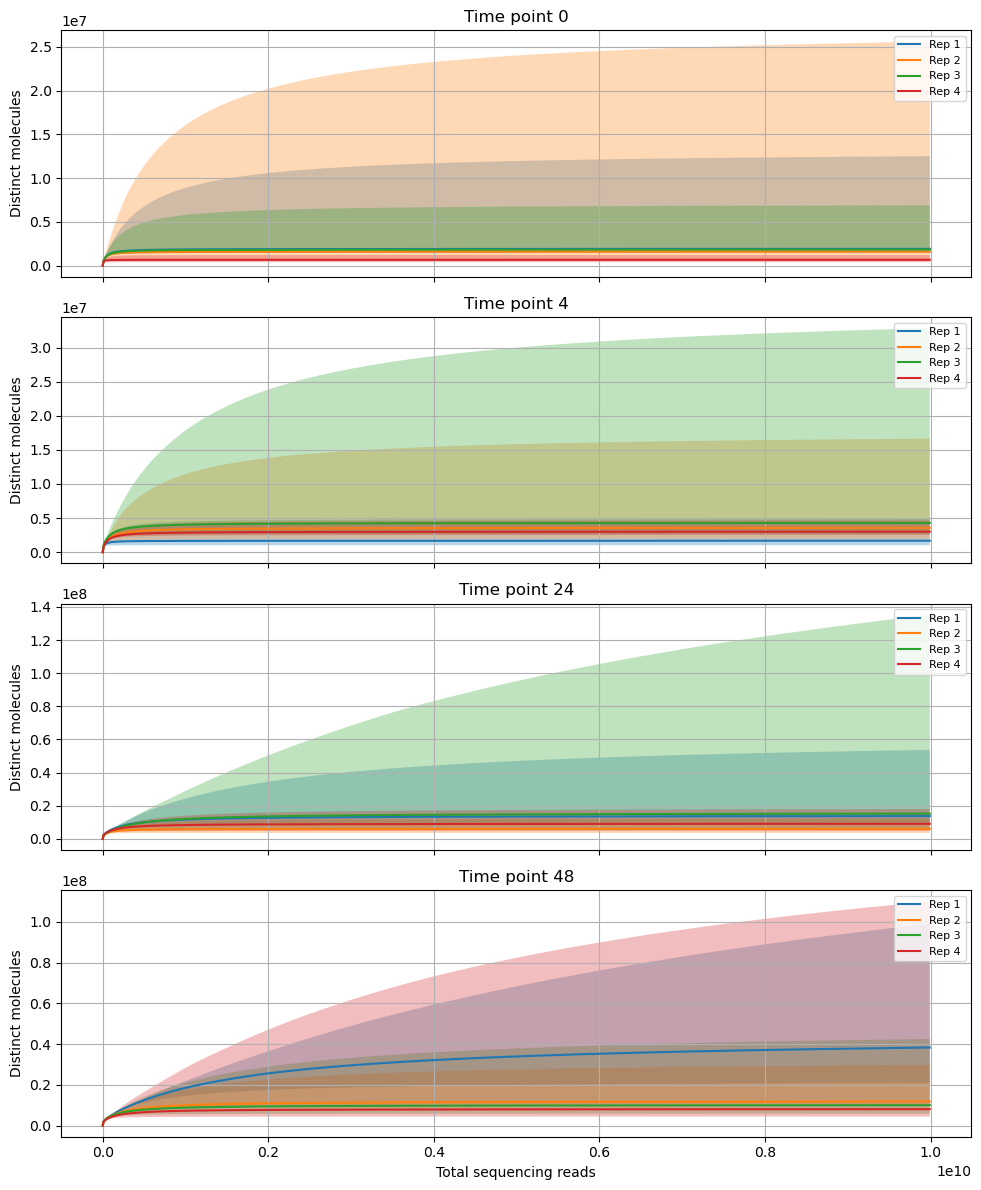

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import os
import re

# -------------------------------
# Parameters
# -------------------------------
DOWNSAMPLE = 10

# -------------------------------
# Find preseq output files
# -------------------------------
preseq_files = glob(os.path.join(BASE_DIR, "*RTBC*", "preseq_yield.txt"))
print(f"Found {len(preseq_files)} preseq yield files")

# -------------------------------
# Extract replicate and time from folder names
# -------------------------------
file_info = []
for f in preseq_files:
    folder_name = os.path.basename(os.path.dirname(f))
    
    # Extract replicate "R*" and time point "T*" using regex
    rep_match = re.search(r'_R(\d+)_', folder_name)
    time_match = re.search(r'_T(\d+)_', folder_name)
    
    if rep_match and time_match:
        rep = int(rep_match.group(1))
        time_pt = int(time_match.group(1))
        file_info.append((time_pt, rep, f))
    else:
        print(f"Could not parse {folder_name}")

# -------------------------------
# Organize files by time point
# -------------------------------
from collections import defaultdict
timepoint_files = defaultdict(list)
for time_pt, rep, f in file_info:
    timepoint_files[time_pt].append((rep, f))

# Sort replicates within each time point
for time_pt in timepoint_files:
    timepoint_files[time_pt] = sorted(timepoint_files[time_pt], key=lambda x: x[0])

# -------------------------------
# Create subplots (1 row per time point)
# -------------------------------
timepoints = sorted(timepoint_files.keys())
n_timepoints = len(timepoints)
fig, axes = plt.subplots(n_timepoints, 1, figsize=(10, 3*n_timepoints), sharex=True)

if n_timepoints == 1:
    axes = [axes]

for ax, time_pt in zip(axes, timepoints):
    for rep, f in timepoint_files[time_pt]:
        df = pd.read_csv(
            f,
            sep='\t',
            comment='#',
            header=None,
            names=['total_reads', 'expected_distinct', 'lower_CI', 'upper_CI']
        )
        
        df = df.apply(pd.to_numeric, errors='coerce').dropna()
        df = df.iloc[::DOWNSAMPLE, :]
        
        ax.plot(df['total_reads'], df['expected_distinct'], label=f"Rep {rep}")
        ax.fill_between(df['total_reads'], df['lower_CI'], df['upper_CI'], alpha=0.3)
    
    ax.set_ylabel("Distinct molecules")
    ax.set_title(f"Time point {time_pt}")
    ax.legend(fontsize=8)
    ax.grid(True)

axes[-1].set_xlabel("Total sequencing reads")
plt.tight_layout()
plt.show()

Found 16 preseq yield files


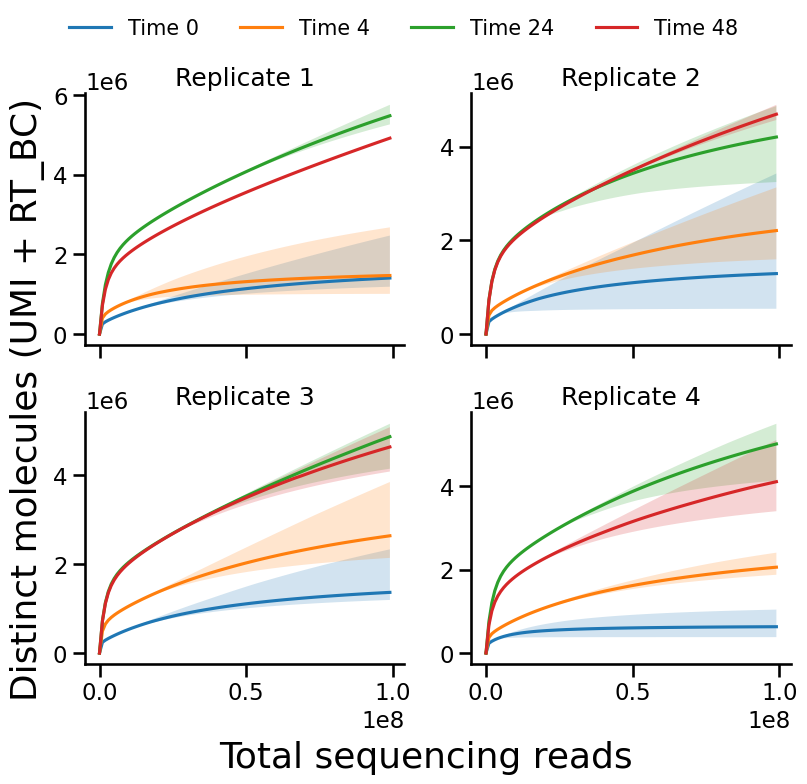

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import os
import re
from collections import defaultdict
import seaborn as sns

# -------------------------------
# Parameters
# -------------------------------
DOWNSAMPLE = 1

# -------------------------------
# Find preseq output files
# -------------------------------
preseq_files = glob(os.path.join(BASE_DIR, "*RTBC*", "preseq_yield.txt"))
print(f"Found {len(preseq_files)} preseq yield files")

# -------------------------------
# Extract replicate and time from folder names
# -------------------------------
file_info = []
for f in preseq_files:
    folder_name = os.path.basename(os.path.dirname(f))
    
    rep_match = re.search(r'_R(\d+)_', folder_name)
    time_match = re.search(r'_T(\d+)_', folder_name)
    
    if rep_match and time_match:
        rep = int(rep_match.group(1))
        time_pt = int(time_match.group(1))
        file_info.append((rep, time_pt, f))
    else:
        print(f"Could not parse {folder_name}")

# -------------------------------
# Organize files by replicate
# -------------------------------
rep_files = defaultdict(list)
for rep, time_pt, f in file_info:
    rep_files[rep].append((time_pt, f))

# Sort time points within each replicate
for rep in rep_files:
    rep_files[rep] = sorted(rep_files[rep], key=lambda x: x[0])

# -------------------------------
# Create subplots
# -------------------------------
sns.set_context('talk')
reps = sorted(rep_files.keys())
n_reps = len(reps)
ncols = 2
nrows = (n_reps + ncols - 1) // ncols  # automatic rows
fig, axes = plt.subplots(nrows, ncols, figsize=(8,8), sharex=True)
axes = axes.flatten()

# Keep track of all legend labels for one combined legend
all_labels = {}

for ax, rep in zip(axes, reps):
    for time_pt, f in rep_files[rep]:
        df = pd.read_csv(
            f,
            sep='\t',
            comment='#',
            header=None,
            names=['total_reads', 'expected_distinct', 'lower_CI', 'upper_CI']
        )
        df = df.apply(pd.to_numeric, errors='coerce').dropna()
        df = df.iloc[::DOWNSAMPLE, :]
        df = df[df["total_reads"] < 10 ** 8]
        
        # Store label for combined legend
        label = f"Time {time_pt}"
        all_labels[label] = df['expected_distinct']
        
        ax.plot(df['total_reads'], df['expected_distinct'], label=label)
        ax.fill_between(df['total_reads'], df['lower_CI'], df['upper_CI'], alpha=0.2)

        #ax.axvline(20213793)
    
    ax.set_title(f"Replicate {rep}")
    ax.grid(False)

# Remove unused axes
for ax in axes[len(reps):]:
    ax.set_visible(False)

# Shared labels
fig.text(0.5, 0.04, "Total sequencing reads", ha='center', fontsize='x-large')
fig.text(-0.02, 0.5, "Distinct molecules (UMI + RT_BC)", va='center', rotation='vertical', fontsize='x-large')

# Single legend outside the plot
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, fontsize='small', frameon=False)


plt.tight_layout(rect=[0, 0.05, 1, 0.95])
sns.despine()
plt.show()